--- BAŞLATILIYOR ---
Cihaz: cuda
Toplam Resim Sayısı: 78764

Model eğitiliyor... (15 Epoch)
Epoch [1/15] | Loss: 0.3473 | Acc: %90.5 | Val Acc: %90.7
Epoch [2/15] | Loss: 0.3403 | Acc: %90.6 | Val Acc: %90.8
Epoch [3/15] | Loss: 0.3289 | Acc: %90.6 | Val Acc: %90.8
Epoch [4/15] | Loss: 0.3278 | Acc: %90.6 | Val Acc: %90.8
Epoch [5/15] | Loss: 0.3276 | Acc: %90.6 | Val Acc: %90.8
Epoch [6/15] | Loss: 0.3279 | Acc: %90.6 | Val Acc: %90.8
Epoch [7/15] | Loss: 0.3275 | Acc: %90.6 | Val Acc: %90.8
Epoch [8/15] | Loss: 0.3274 | Acc: %90.6 | Val Acc: %90.8
Epoch [9/15] | Loss: 0.3275 | Acc: %90.6 | Val Acc: %90.8
Epoch [10/15] | Loss: 0.3277 | Acc: %90.6 | Val Acc: %90.8
Epoch [11/15] | Loss: 0.3276 | Acc: %90.6 | Val Acc: %90.8
Epoch [12/15] | Loss: 0.3276 | Acc: %90.6 | Val Acc: %90.8
Epoch [13/15] | Loss: 0.3274 | Acc: %90.6 | Val Acc: %90.8
Epoch [14/15] | Loss: 0.3274 | Acc: %90.6 | Val Acc: %90.8
Epoch [15/15] | Loss: 0.3273 | Acc: %90.6 | Val Acc: %90.8
Tamamlandı. Süre: 76.0 dk
Grafik

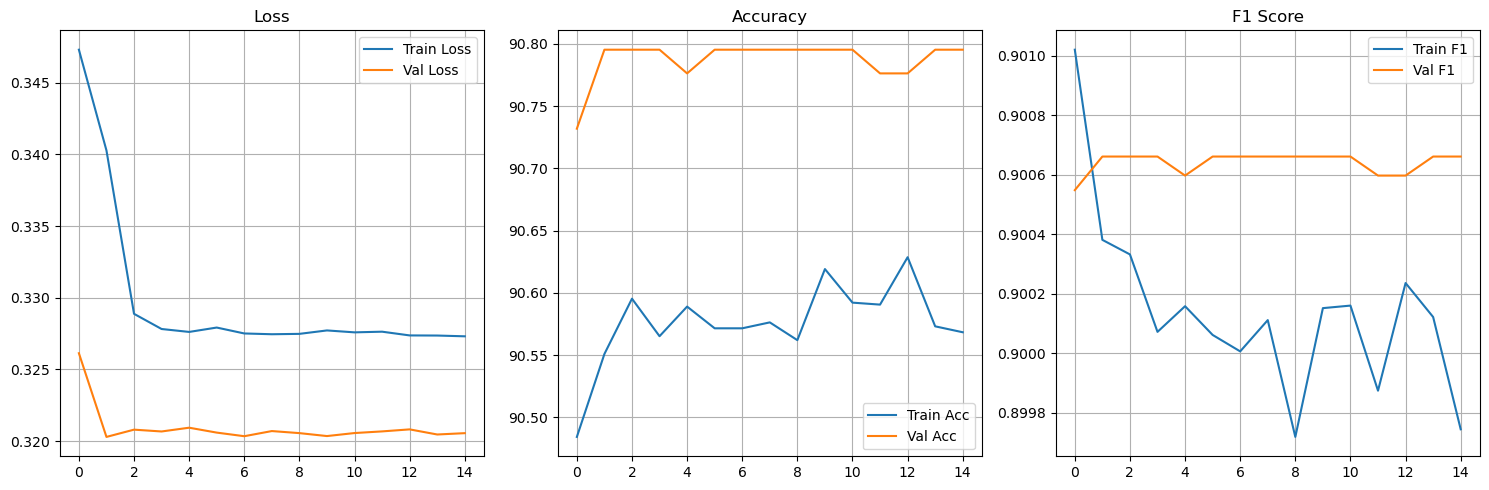

In [1]:
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


VERI_DOSYASI = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\Enes Arslan\Bitki Projesi\New Plant Diseases Dataset(Augmented)\train'

BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCH_SAYISI = 15  
RESIM_BOYUTU = 128


class SafGenisCNN(nn.Module):
    def __init__(self, num_classes):
        super(SafGenisCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class BitkiVeriSetim(Dataset):
    def __init__(self, dosya_yolu, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        try:
            self.veriler = pd.read_csv(dosya_yolu)
            if self.veriler.shape[1] < 2:
                self.veriler = pd.read_csv(dosya_yolu, sep=';')
        except Exception as e:
            print(f"CSV Okuma Hatası: {e}")
            raise

        self.sinif_isimleri = sorted(self.veriler.iloc[:, 1].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
    def __len__(self):
        return len(self.veriler)

    def __getitem__(self, idx):
        dosya_adi = str(self.veriler.iloc[idx, 0])
        sinif_ismi = self.veriler.iloc[idx, 1]
        resim_yolu = os.path.join(self.root_dir, dosya_adi)
        
        try:
            image = Image.open(resim_yolu).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            
            return torch.zeros((3, RESIM_BOYUTU, RESIM_BOYUTU)), 0


if __name__ == '__main__':
    
    if not os.path.exists(VERI_DOSYASI):
        print(f"!!! HATA !!! CSV Dosyası Yok: {VERI_DOSYASI}")
        exit() 
    if not os.path.exists(ANA_KLASOR):
        print(f"!!! HATA !!! Resim Klasörü Yok: {ANA_KLASOR}")
        exit()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- BAŞLATILIYOR ---\nCihaz: {device}")
    
    
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    try:
        
        full_dataset = BitkiVeriSetim(dosya_yolu=VERI_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        print(f"Toplam Resim Sayısı: {len(full_dataset)}")

        if len(full_dataset) == 0:
            raise ValueError("Dataset boş geldi!")

        
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        
        model = SafGenisCNN(len(full_dataset.sinif_isimleri)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}

        print(f"\nModel eğitiliyor... ({EPOCH_SAYISI} Epoch)")
        baslangic_zamani = time.time()

        for epoch in range(EPOCH_SAYISI):
           
            model.train()
            running_loss = 0.0
            train_preds, train_targets = [], []

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_preds.extend(predicted.cpu().numpy())
                train_targets.extend(labels.cpu().numpy())

            avg_train_loss = running_loss / len(train_loader)
            train_acc = 100 * sum([1 for i, j in zip(train_preds, train_targets) if i == j]) / len(train_targets)
            train_f1 = f1_score(train_targets, train_preds, average='weighted')

            
            model.eval()
            val_loss = 0.0
            val_preds, val_targets = [], []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_targets.extend(labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_acc = 100 * sum([1 for i, j in zip(val_preds, val_targets) if i == j]) / len(val_targets)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')

            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['train_f1'].append(train_f1)
            history['val_f1'].append(val_f1)

            print(f"Epoch [{epoch+1}/{EPOCH_SAYISI}] | Loss: {avg_train_loss:.4f} | Acc: %{train_acc:.1f} | Val Acc: %{val_acc:.1f}")

        print(f"Tamamlandı. Süre: {(time.time() - baslangic_zamani)/60:.1f} dk")
        torch.save(model.state_dict(), 'son_model_detayli.pth')

        
        print("Grafikler çiziliyor...")
        plt.figure(figsize=(15, 5))

        
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid()

       
        plt.subplot(1, 3, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.title('Accuracy')
        plt.legend()
        plt.grid()

       
        plt.subplot(1, 3, 3)
        plt.plot(history['train_f1'], label='Train F1')
        plt.plot(history['val_f1'], label='Val F1')
        plt.title('F1 Score')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.savefig('egitim_sonuclari.png')
        print("Grafik kaydedildi: egitim_sonuclari.png")
        plt.show()

    except Exception as e:
        print("\n!!!!!!!! BİR HATA OLUŞTU !!!!!!!!")
        print(e)
        import traceback
        traceback.print_exc() 